## **Импорты**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy.integrate import quad

## **Границы**

In [3]:
rng = 5

a = -rng
b = rng
prec = 0.01

## **Отрисовка**

In [4]:
def ShowArr(arr , name):
  plt.figure(figsize=(14,3))
  plt.title(name)
  axis = np.arange(a,b,prec) 
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()

def ShowFourier(arr, name):
  plt.figure(figsize=(14,3))
  plt.title(name)
  axis = [i*1/prec/len(arr) for i in range(len(arr))]
  plt.xlim (0, np.max(axis)/2)
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()


## **Свертка**

In [5]:
def convol(func1 , func2):
  conv = np.convolve(func1 ,func2)
  a1 = abs(round(a/prec))
  b1 = abs(round((b-a)/prec)) + abs(round(a/prec))
  return conv[a1:b1]

## **Оригинал фильтра**

In [6]:
def rect(w1,w2):
  return lambda x: 1 if w1<x and x<w2 else 0
def rect_slider(w1,w2,s):
  return lambda x: 1 if w1<x and x<w2 else max(1 -  (abs(x) + w1)/s,0) if x<w1 else max(1 -  (abs(x)- w2)/s,0) if x>w2 else 0

def phaseMode(rect_arr):
  steps = 0
  for i in rect_arr:
    if i == 1:
      steps+=1
  phase = np.array([np.exp(1j*0) for i in rect_arr])
  result = np.array([rect_arr[idx]*phase[idx] for idx in range(rect_arr.shape[0])])
  step = 0
  for idx in range(rect_arr.shape[0]):
    if rect_arr[idx] == 1:
      result[idx] *= np.exp(1j*(np.pi - 2*np.pi*step/steps))
      step += 1
    else:
      result[idx] = rect_arr[idx]

  #ShowArr(np.abs(result),'Abs')
  #ShowArr(np.angle(result),'Image')

  return result

def rect2(a,b):
  return lambda x: 0 if (x<a)or(x>b) else np.cos(np.pi/(2*(b-a))*x)+1j*np.sin(np.pi/(2*(b-a))*x)

def filter(w1,w2):

  if w1<= 0 and w2 <=0 :
    rect_arr = np.array([rect(-w1,-w2)(i) for i in np.arange(0,b-a,prec)])
    rect_arr = np.where(rect_arr == 1 , 0 , 1)
  else:
    rect_arr = np.array([rect(w1,w2)(i) for i in np.arange(0,b-a,prec)])
 
  result = phaseMode(rect_arr)
  result = rect_arr

  furier_ideal = np.concatenate([result[:len(result)//2], np.flip(result[:len(result)//2])])

  #ShowArr(np.abs(furier_ideal) , "result abs")
  #ShowArr(np.angle(furier_ideal) , "result angle ")

  fil = np.fft.ifft(furier_ideal)
  tmp = np.split(fil, 2)  
  return np.concatenate([tmp[1], tmp[0]])

# **Функции для тестов**

##**Фильтры частот**

In [7]:
def lowFilter(a1 , r1 , r2):
  ideal_fil = filter(-1,a1)

  rct = [rect_slider(r1,r2,0.7)(x) for x in np.arange(a,b,prec)]
  fil = rct * ideal_fil

  ShowFourier(np.abs(np.fft.fft(ideal_fil)) ,"Ideal filter fourier")
  ShowFourier(np.abs(np.fft.fft(fil)) , 'Filter fourier')

  ShowArr(np.real(ideal_fil),"Ideal Filter real")
  ShowArr(np.real(fil),"Filter real")

  ShowFourier(np.imag(np.fft.fft(ideal_fil)) ,"Ideal filter imag")
  ShowFourier(np.imag(np.fft.fft(fil)) , 'Filter imag')

  return fil

In [8]:
def lowPassFilter(func,a1, r1,r2): 
  a1 = a1/50*rng

  fil = lowFilter(a1 , r1,r2)

  func_res = [func(i) for i in np.arange(a,b,prec) ]
  result = np.real(convol(func_res , fil))

  four_sign = np.fft.fft([func(i) for i in np.arange(a,b,prec)])
  ShowFourier(abs(four_sign),"Function fourier before")
  ShowFourier(np.abs(np.fft.fft(result)) , "Function fourier after")

  ShowArr(func_res,"Before filter")
  ShowArr(result,"After filter")

In [9]:
def highPassFilter(func,a1, r1,r2): 
  a1 = a1/50*rng
  ideal_fil = filter(-1,a1)
  rct = [rect_slider(r1,r2,0.7)(x) for x in np.arange(a,b,prec)]
  fil = rct * ideal_fil

  func_arr = [func(i) for i in np.arange(a,b,prec)]
  result = func_arr - np.real(convol(func_arr , fil))
  
  ShowFourier(np.abs(np.fft.fft(func_arr)),"Function fourier before")
  ShowFourier(np.abs(np.fft.fft(result)) , "Function fourier after")

  ShowArr(func_arr, "Before filtering")  
  ShowArr(result , "After filtering")

  arr2 = np.zeros_like(func_arr)
  arr2[10] = 1

  result2 = arr2 - np.real(convol(arr2 , fil))
 
  freq = np.fft.fft(result2)
  ShowFourier(np.abs(freq) , "АЧХ")


In [14]:
def bandPassFilter(func,a1, b1, r1,r2): 
  a1 = a1/50*rng
  b1 = b1/50*rng
  ideal_fil = filter(-1,b1)
  rct = [rect_slider(r1,r2,0.7)(x) for x in np.arange(a,b,prec)]
  fil1 = rct * ideal_fil

  func_arr = [func(i) for i in np.arange(a,b,prec)]
  lp_result = np.real(convol(func_arr , fil1))


  ideal_fil = filter(-1,a1)
  rct = [rect_slider(r1,r2,0.7)(x) for x in np.arange(a,b,prec)]
  fil2 = rct * ideal_fil

  result = lp_result - np.real(convol(lp_result , fil2))

  ShowArr(func_arr , "Before")
  ShowArr(result, "After")

  arr2 = np.zeros_like(func_arr)
  arr2[10] = 1

  lp_result = np.real(convol(arr2 , fil1))
 
  result2 = lp_result - np.real(convol(lp_result , fil2))

  freq = np.fft.fft(result2)
  ShowFourier(np.abs(freq) , "АЧХ")




In [21]:
def bandStopFilter(func,a1, b1, r1,r2): 
  a1 = a1/50*rng
  b1 = b1/50*rng
  ideal_fil = filter(-1,b1)
  rct = [rect_slider(r1,r2,0.7)(x) for x in np.arange(a,b,prec)]
  fil1 = rct * ideal_fil

  func_arr = [func(i) for i in np.arange(a,b,prec)]
  lp_result = np.real(convol(func_arr , fil1))

  ideal_fil = filter(-1,a1)
  rct = [rect_slider(r1,r2,0.7)(x) for x in np.arange(a,b,prec)]
  fil2 = rct * ideal_fil

  result = lp_result - np.real(convol(lp_result , fil2))

  result = func_arr - result

  ShowArr(func_arr , "Before")
  ShowArr(result, "After")

  arr2 = np.zeros_like(func_arr)
  arr2[10] = 1

  lp_result = np.real(convol(arr2 , fil1))
 
  result2 = lp_result - np.real(convol(lp_result , fil2))

  result2 = arr2 - result2

  freq = np.fft.fft(result2)
  ShowFourier(np.abs(freq) , "АЧХ")

# **Тесты**

## **Фильтры частот**

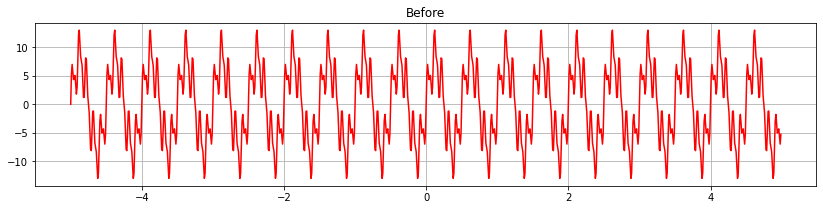

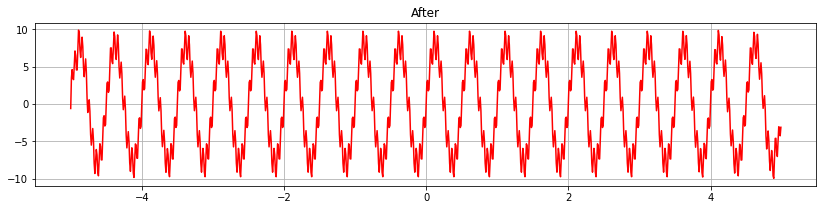

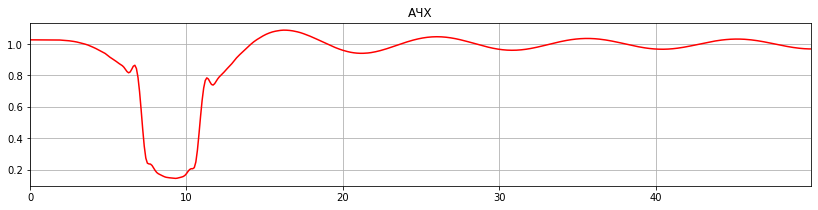

In [22]:
def cos_sin(a1,a2,w1,w2):
  return lambda x: a1*np.cos(w1*x*np.pi*2) + a2*np.sin(w2*x*np.pi*2)

def sin_sin_sin(a1,a2,a3,w1,w2,w3):
  return lambda x: a1*np.sin(w1*x*np.pi*2)+a2*np.sin(w2*x*np.pi*2)+a3*np.sin(w3*x*np.pi*2)


#bandPassFilter(sin_sin_sin(8,4,2,  2,10,20) ,1 ,3, -1,1)

bandStopFilter(sin_sin_sin(8,4,2,  2,10,20) ,7 ,11, -1,1)
